In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable as V
import torch.nn.functional as F


# New stuff.
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

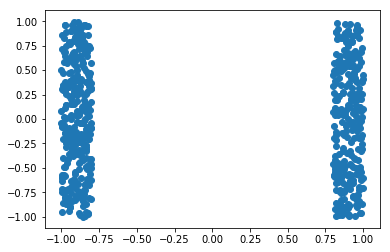

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
r = np.random.random([3000,2]) * 2 - 1.0
# Label points within a circle.
X = np.array([r[i] for i in range(r.shape[0]) if r[i,0] < -0.8 or r[i,0] > 0.8 ] )# and np.linalg.norm(r[i]) > 0.7])
plt.scatter(x =X[:, 0], y = X[:, 1])

In [3]:
LATENT_DIM = 8

# Compute the variational parameters for q
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(2, 200)
        self.linear2 = nn.Linear(200, LATENT_DIM)
        self.linear3 = nn.Linear(200, LATENT_DIM)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        return self.linear2(h), self.linear3(h) 

In [4]:
# Implement the generative model p(x | z)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 200)
        self.linear2 = nn.Linear(200, 2)

    def forward(self, z):
        return self.linear2(F.relu(self.linear1(z)))

In [5]:
# VAE using reparameterization "rsample"

class NormalVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(NormalVAE, self).__init__()

        # Parameters phi and computes variational parameters lambda
        self.encoder = encoder

        # Parameters theta, p(x | z)
        self.decoder = decoder
    
    def forward(self, x_src):
        # Example variational parameters lambda
        mu, logvar = self.encoder(x_src)
        
        q_normal = Normal(loc=mu, scale=logvar.mul(0.5).exp())

        # Reparameterized sample.
        z_sample = q_normal.rsample()
        #z_sample = mu
        return self.decoder(z_sample), q_normal        

634 1.2236697726779513 0.08741735529016566
634 1.1858184814453125 0.10285142969202113
634 1.1673569290726273 0.11373414640073423
634 1.1217796043113426 0.132163902565285
634 1.0838296395760996 0.15316701818395545
634 1.0764360215928819 0.16041946411132812
634 1.076873779296875 0.1639566209581163
634 1.0656419542100695 0.16601425453468605
634 1.050773451063368 0.170446127432364
634 1.0595933702256946 0.17000452677408853
634 1.0535702175564237 0.1722860124376085
634 1.0461264151114005 0.17525093643753617
634 1.038704992223669 0.18154270030834058
634 1.0526084617332176 0.17510107534903066
634 1.0401058620876735 0.18177743134675203
634 1.0355541087962963 0.17703884266040942
634 1.0415822347005208 0.17266712895146122
634 1.0326960810908565 0.18792605929904513
634 1.0303389937789351 0.1861239963107639
634 1.0265003345630788 0.18801869992856626


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


634 1.0304801658347802 0.17893842061360676
634 1.024177607783565 0.18870405974211515
634 1.0352039478443287 0.18425425776728876
634 1.0243784586588542 0.187310466059932
634 1.027200769495081 0.1917342433223018
634 1.0187661630135996 0.19055230882432725
634 1.0107694272641783 0.20406778123643662
634 1.0068466751663774 0.19680006239149306
634 1.0188516122323494 0.20068292971010562
634 1.013164378978588 0.20587372956452546
634 1.0036187065972222 0.20616038287127458
634 0.9875411422164352 0.20612627665201824
634 0.991107968930845 0.20341614617241754
634 0.9885265209056713 0.2096764741120515
634 0.9696117259837963 0.228142985591182
634 0.9498336226851852 0.2395465992115162
634 0.9562244556568287 0.23695718270760996
634 0.9573843496817129 0.23451468856246382
634 0.9554488570601852 0.22992142571343316
634 0.9449688381618924 0.24744045116283275
634 0.9327154654043692 0.25142347547743055
634 0.9441488195348668 0.2392923425745081
634 0.9454439516420717 0.24259295993381078
634 0.9531560827184606 

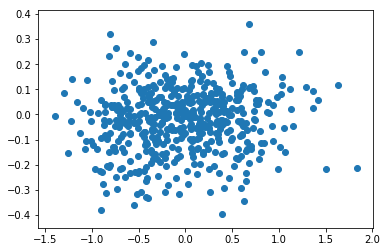

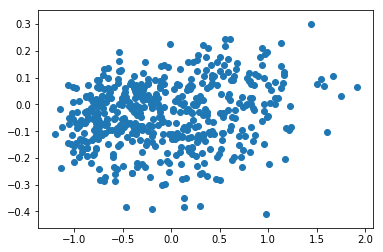

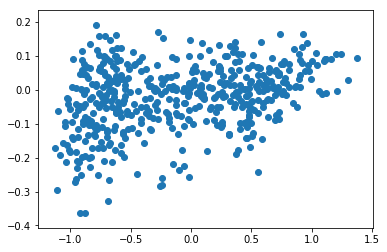

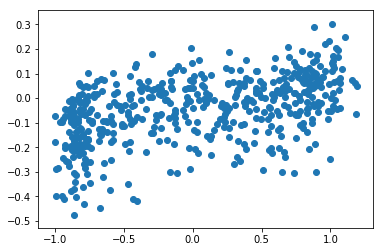

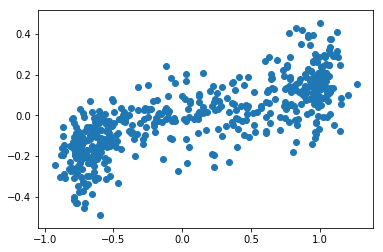

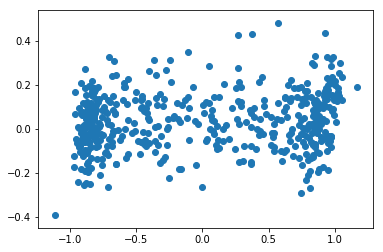

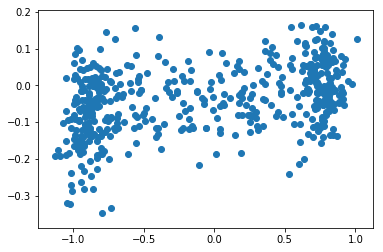

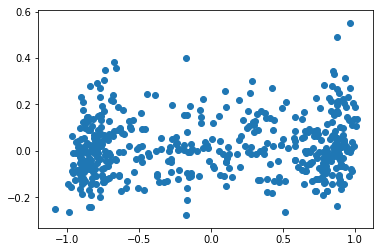

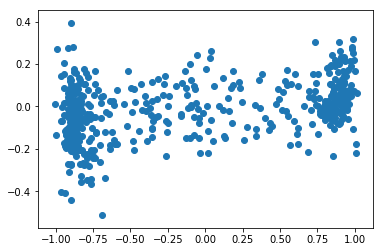

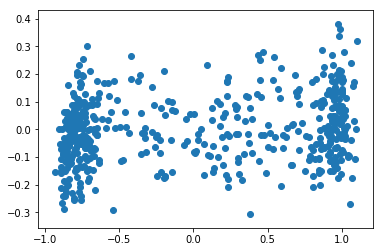

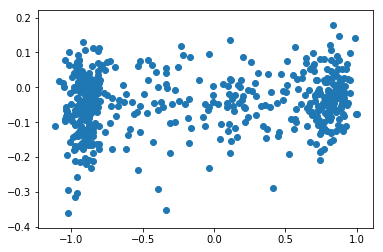

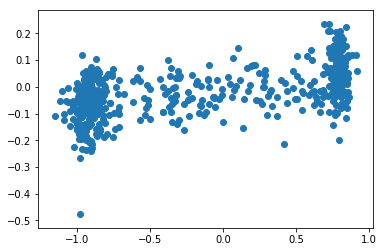

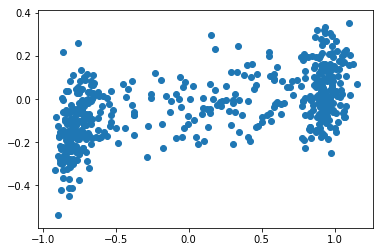

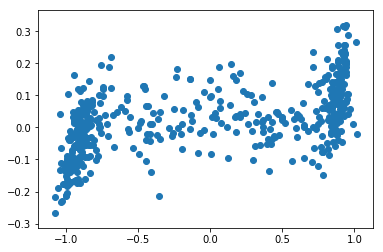

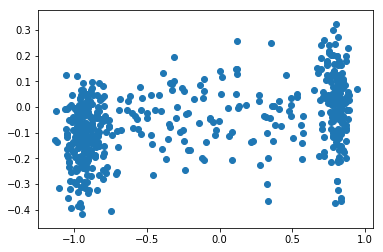

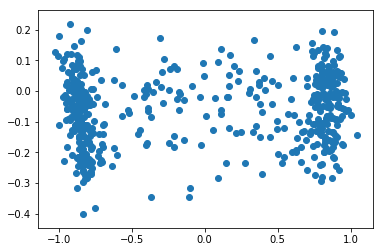

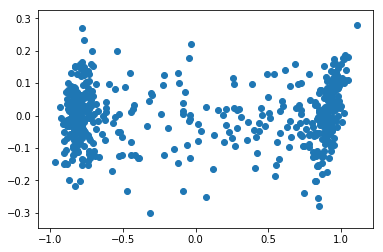

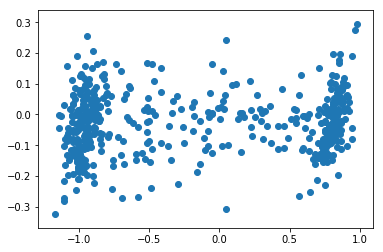

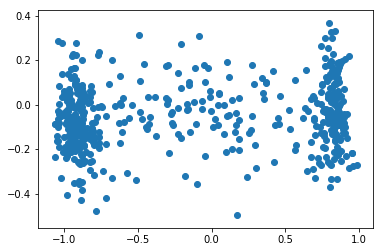

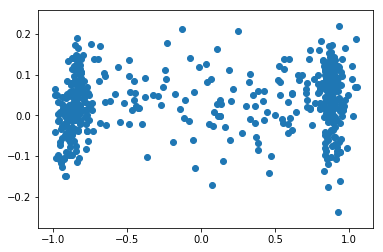

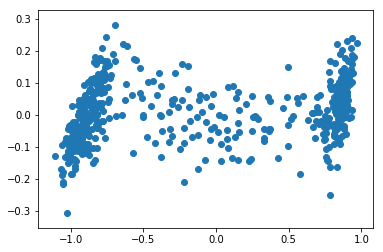

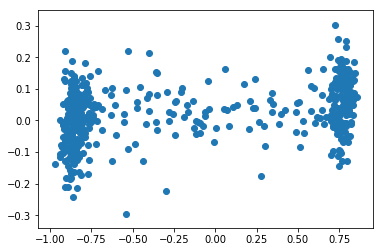

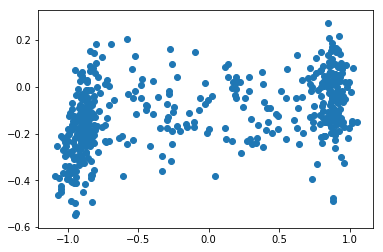

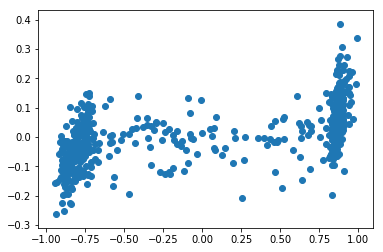

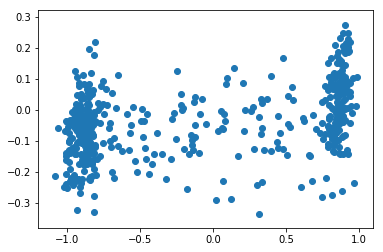

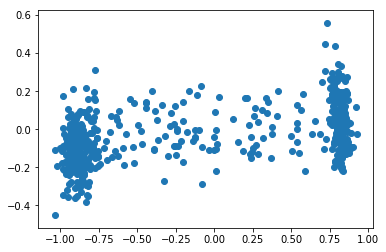

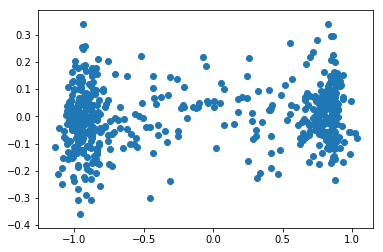

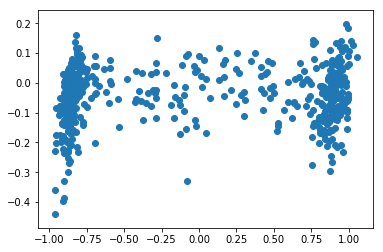

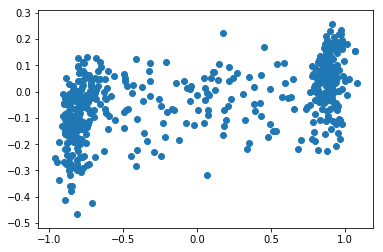

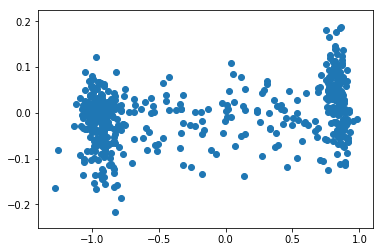

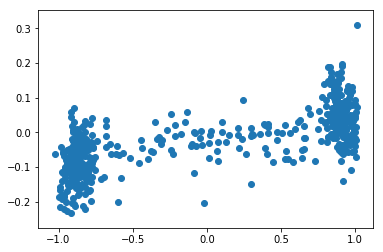

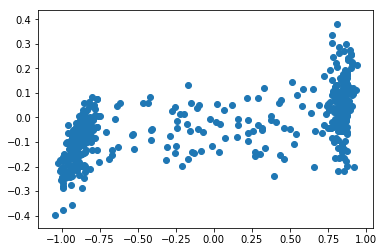

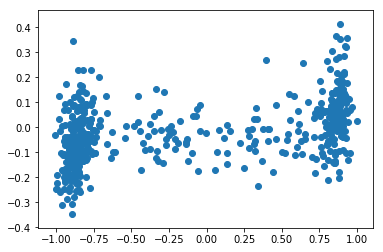

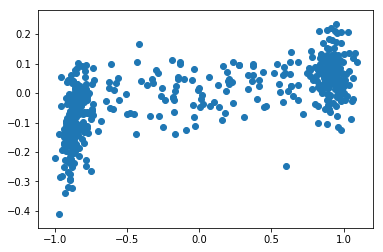

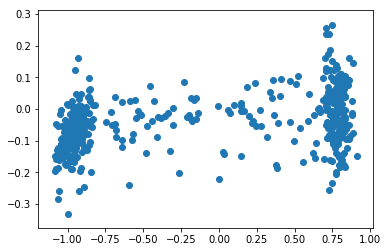

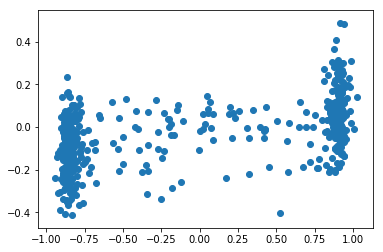

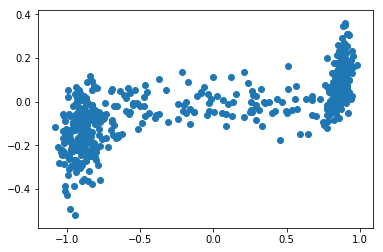

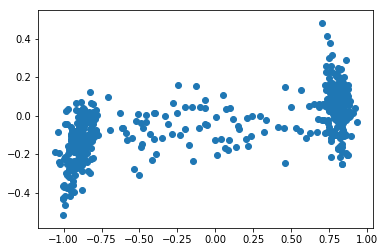

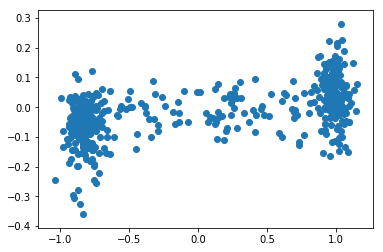

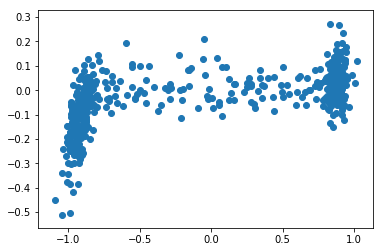

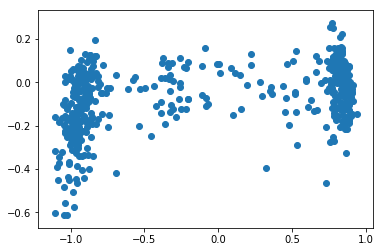

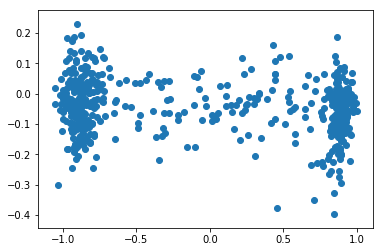

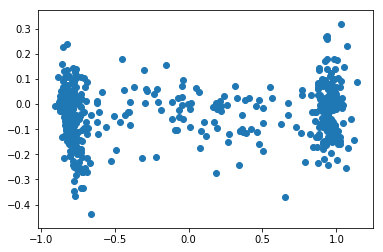

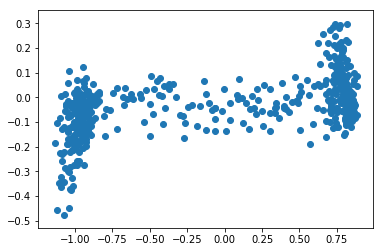

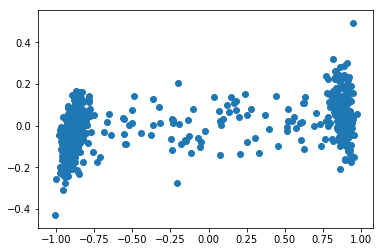

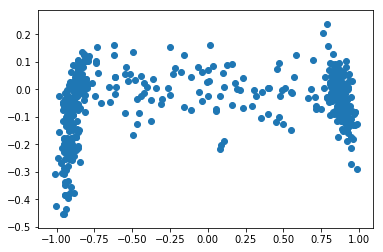

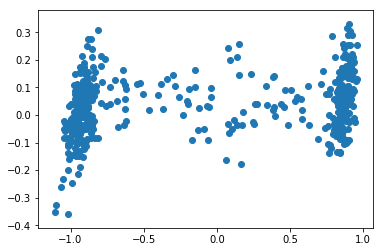

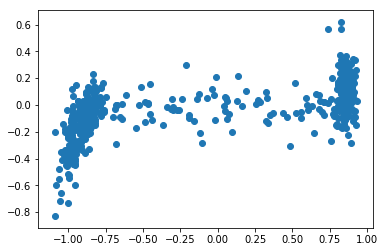

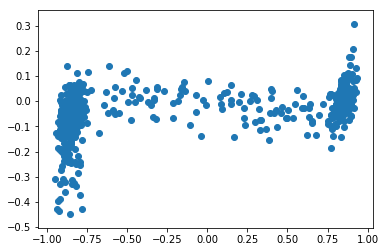

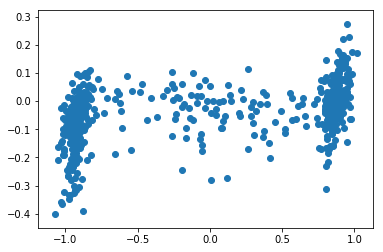

In [8]:
BATCH_SIZE = 32

mse_loss = nn.L1Loss(size_average=False)

# Problem setup.
encoder = Encoder()
decoder = Decoder()
vae = NormalVAE(encoder, decoder)

# SGD
learning_rate = 0.02
optim = torch.optim.SGD(vae.parameters(), lr = learning_rate)

NUM_EPOCHS = 50

# Get samples.
p = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
           V(torch.ones(BATCH_SIZE, LATENT_DIM)))


for epoch in range(NUM_EPOCHS):
    # Keep track of reconstruction loss and total kl
    total_loss = 0
    total_kl = 0
    total = 0
    alpha = 1
    for i, t in enumerate(X, BATCH_SIZE):
        if X[i:i+BATCH_SIZE].shape[0] < BATCH_SIZE : continue

        # Standard setup. 
        vae.zero_grad()
        x = V(torch.FloatTensor(X[i: i+BATCH_SIZE] ))

        # Run VAE. 
        out, q = vae(x)
        kl = kl_divergence(q, p).sum()

        # actual loss
        loss = mse_loss(out, x) + alpha * kl 
        loss = loss / BATCH_SIZE

        # record keeping.
        total_loss += mse_loss(out, x).data / BATCH_SIZE
        total_kl += kl.data / BATCH_SIZE
        total += 1
        loss.backward()
        optim.step()
    graph_vae()
    print(i, total_loss[0] / total , total_kl[0] / total)

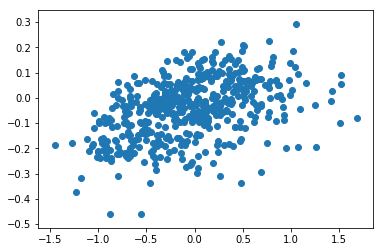

In [7]:
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                        V(torch.ones(BATCH_SIZE, LATENT_DIM)))
def graph_vae():
    fig, axs = plt.subplots(1,1)
    all = []
    all_out = []
    for k in range(500):
        seed =  seed_distribution.sample()
        x = decoder(seed[0:1] )
        all.append(x.data[0].numpy())
       
    all = np.array(all)
    axs.scatter(all[:, 0], all[:, 1])

graph_vae()

In [9]:
print(encoder(V(torch.FloatTensor([-1, 0])) )[0] )
print(encoder(V(torch.FloatTensor([1, 0])) )[0])

Variable containing:
-0.0096
 0.6418
-0.0016
 0.0111
-0.0200
-0.0055
-0.0091
 0.0317
[torch.FloatTensor of size (8,)]

Variable containing:
-0.0031
-0.5853
-0.0035
-0.0072
 0.0119
 0.0182
 0.0068
-0.0391
[torch.FloatTensor of size (8,)]



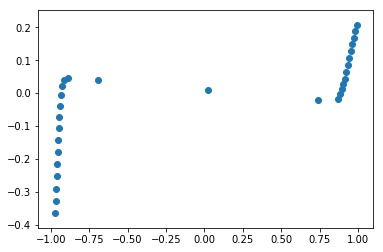

In [10]:
z = V(torch.zeros(8))

all = []
for k in np.linspace(-3, 3, 30):
    seed = seed_distribution.sample()
    z[1] = k
    x = decoder(z)
    all.append(x.data.numpy())
all = np.array(all)
plt.scatter(all[:, 0], all[:, 1])

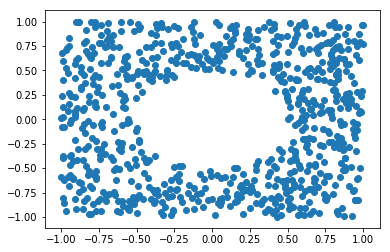

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
r = np.random.random([1000,2]) * 2 - 1.0
# Label points within a circle.
X = np.array([r[i] for i in range(r.shape[0]) if np.linalg.norm(r[i]) > 0.5 ])
plt.scatter(x =X[:, 0], y = X[:, 1])

In [25]:
LATENT_DIM = 32
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 100)
        self.linear2 = nn.Linear(100, 2)
    def forward(self, z):
        return self.linear2(F.relu(self.linear1(z))) 

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(2, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, point):
        return F.sigmoid(self.linear2(F.relu(self.linear1(point))))


In [27]:
G = Generator()
D = Discriminator()
learning_rate = 0.01
optim_gen = torch.optim.SGD(G.parameters(), lr=learning_rate)
optim_disc = torch.optim.SGD(D.parameters(), lr=learning_rate)
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                           V(torch.ones(BATCH_SIZE, LATENT_DIM)))       

805 0.6228364937835269 -0.6256048729792429
805 0.6245231784360353 -0.6139289883064053
805 0.6199491622374039 -0.6103112843147543
805 0.6288603526523255 -0.6256580240350669
805 0.6261372029088265 -0.6216000795210362
805 0.6270622593718905 -0.6234798616987174
805 0.6248599717860382 -0.6206227497845042
805 0.6235923982328839 -0.621397965715221
805 0.6211965083690885 -0.6180345065679969
805 0.6191887446229156 -0.6158577245335246
805 0.6165783661742543 -0.6136805171036289
805 0.6151463983902944 -0.6125542395182666
805 0.6123545458612516 -0.6097581418139681
805 0.6099662347203385 -0.6077831785654221
805 0.6082230884514421 -0.6062985483836142
805 0.6058842731153626 -0.6037671004616937
805 0.6043432402672385 -0.6029698485243844
805 0.6014781474913121 -0.5999356293401052
805 0.6002278061877233 -0.5990449150865392
805 0.5979935078657874 -0.5972213609582078


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


805 0.5976672733553928 -0.59676686114119
805 0.597426294818405 -0.5970673252291766
805 0.5975346358863575 -0.5969517385004719
805 0.5987070622909285 -0.5986551060233005
805 0.5997382558747472 -0.5997371147615349
805 0.6000746713051193 -0.6001025110252144
805 0.6019500327664752 -0.60205255868515
805 0.6030605917060098 -0.6031004938198307
805 0.6040377052794439 -0.6042659988853051
805 0.6062572172214818 -0.6065515975927506
805 0.6081420699139282 -0.608620323105992
805 0.6110527776085437 -0.6113294502407389
805 0.6146397979530561 -0.6146464200752958
805 0.6168992213654579 -0.6169127746453889
805 0.620574274535943 -0.6204360541755223
805 0.6222086988139214 -0.6216840178775541
805 0.6234523861522207 -0.6232510175969865
805 0.6243020459355002 -0.6239644771860552
805 0.6252334008922257 -0.6250165347443071
805 0.6264057314596126 -0.6258863644236434
805 0.6268543165937567 -0.6263196126435154
805 0.6277445520464456 -0.6271847800690998
805 0.6279535097977296 -0.6271135626067179
805 0.628689760039

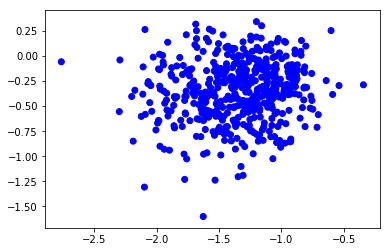

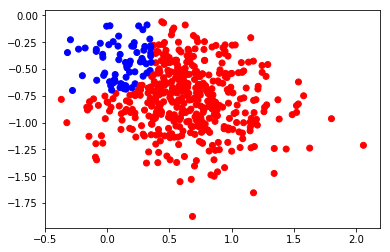

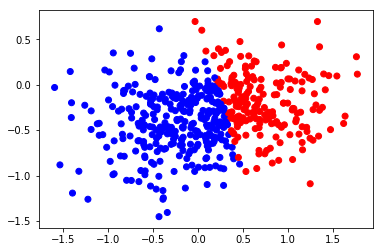

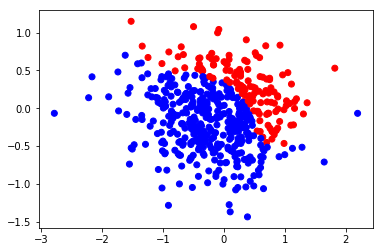

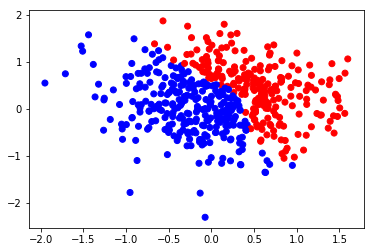

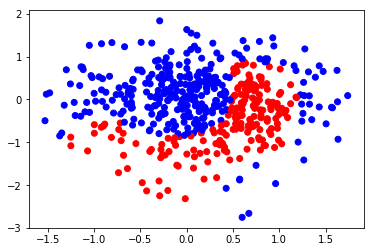

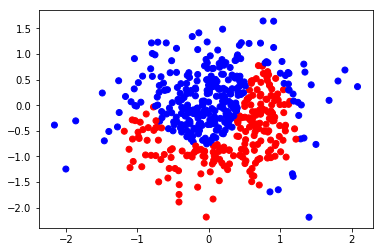

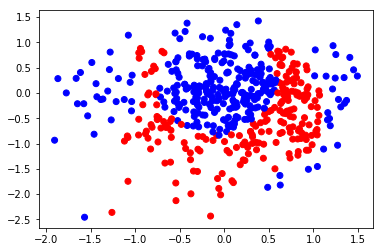

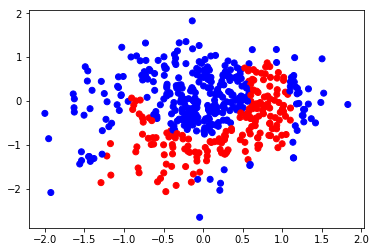

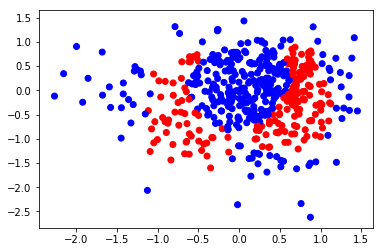

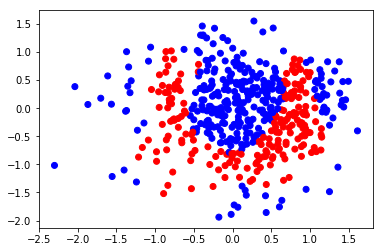

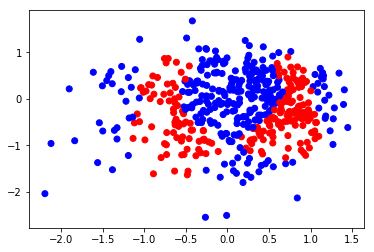

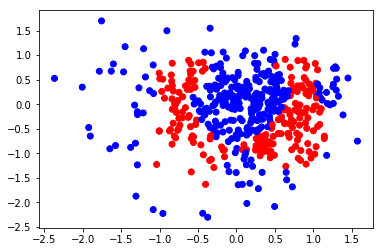

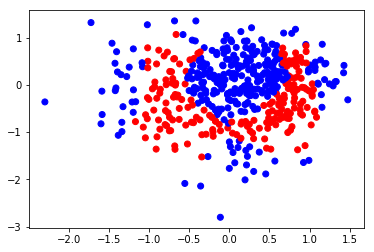

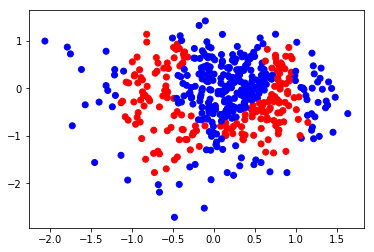

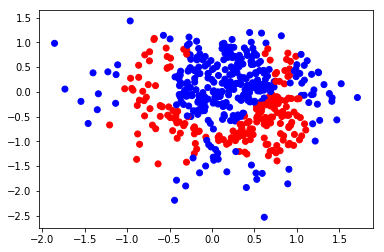

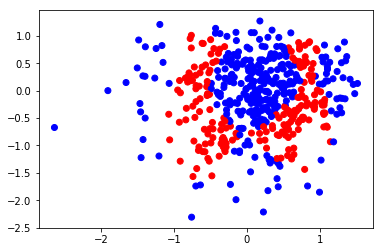

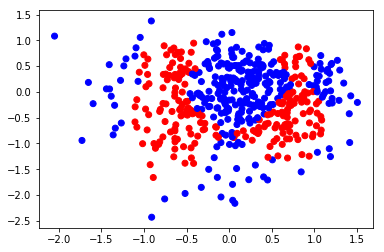

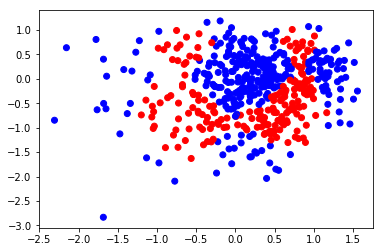

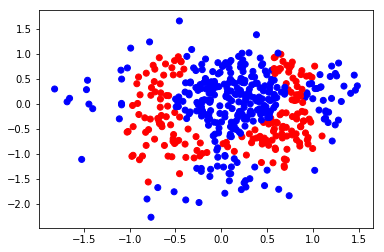

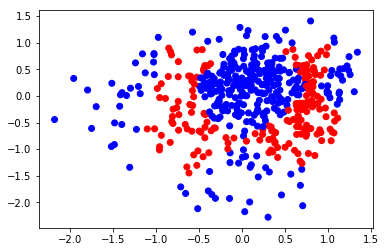

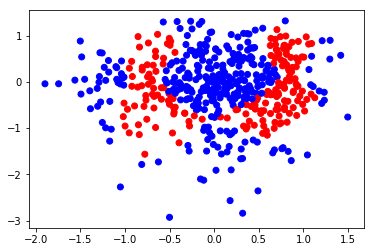

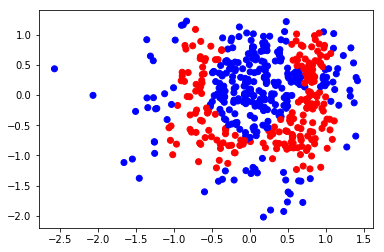

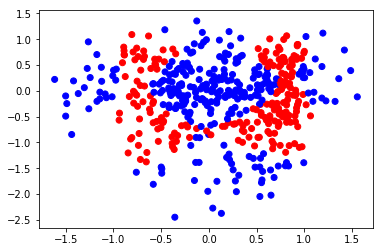

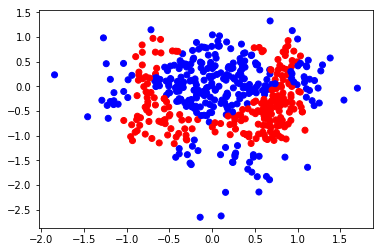

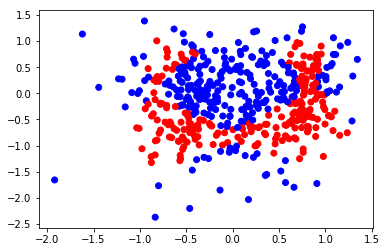

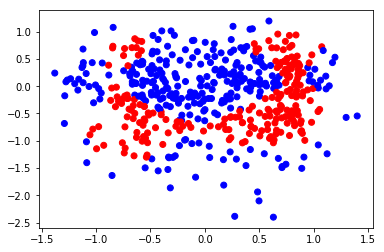

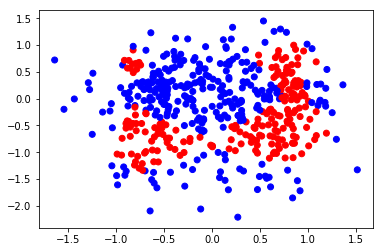

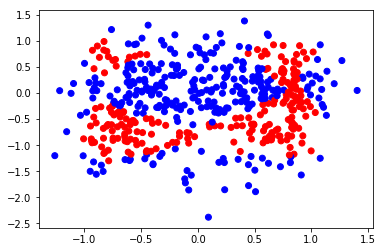

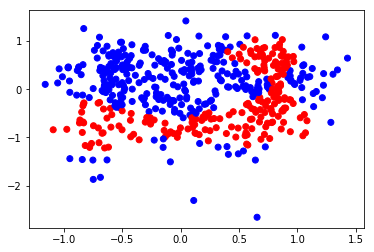

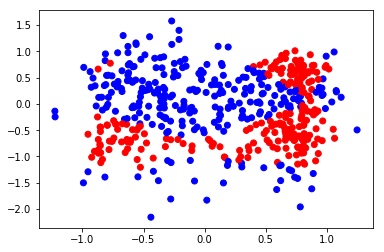

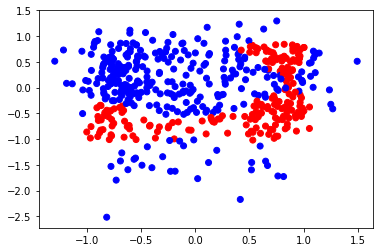

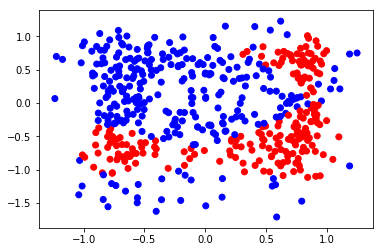

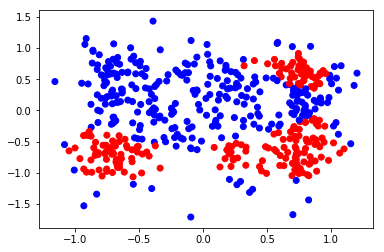

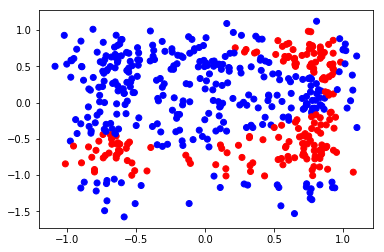

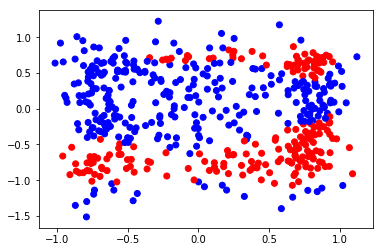

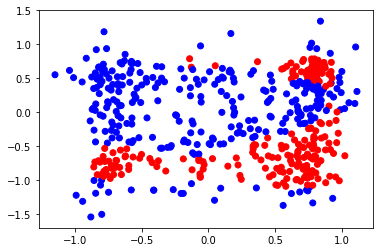

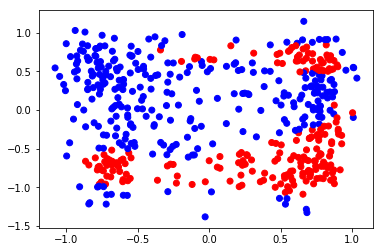

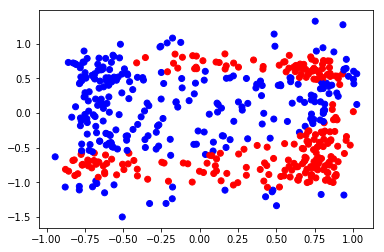

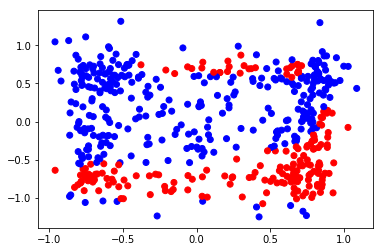

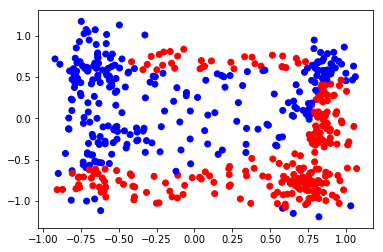

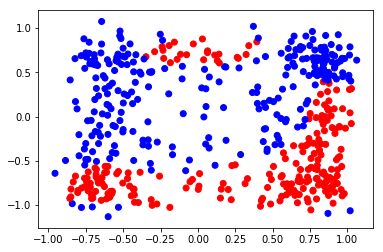

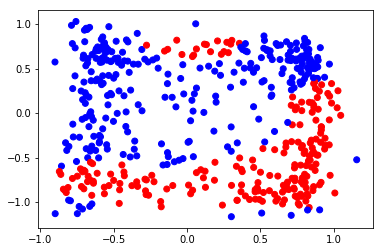

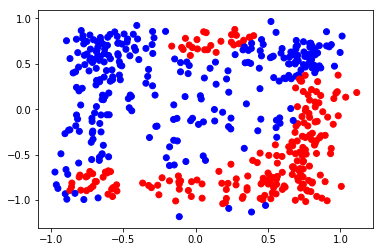

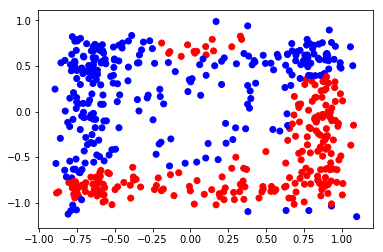

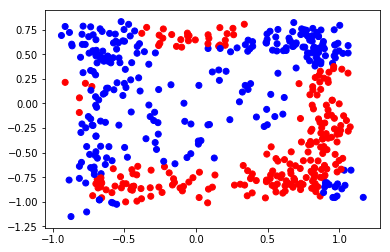

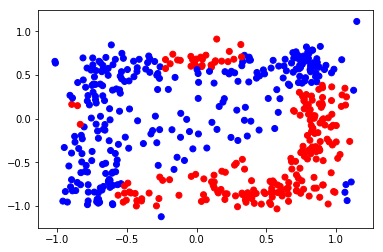

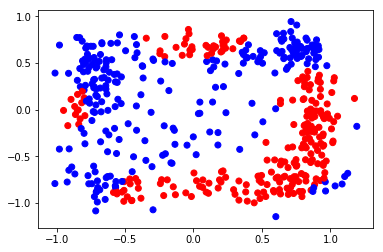

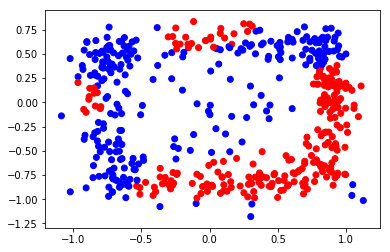

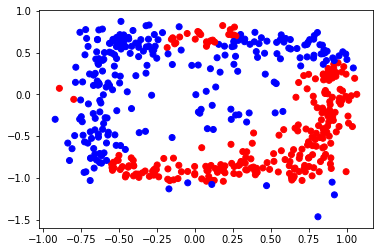

In [28]:

for epoch in range(50):
    total_gen_loss = 0
    total_disc_loss = 0
    for i, t in enumerate(X, BATCH_SIZE):
        if X[i:i+BATCH_SIZE].shape[0] < BATCH_SIZE : continue

        # Grad real
        # -E[log(D(x))]
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        x_real = V(torch.FloatTensor(X[i:i+BATCH_SIZE]))
        d = D(x_real)
        loss_a = 0.5 * -d.log().mean()
        loss_a.backward()
        
        # Grad fake
        # -E[log(1 - D(G(z)) )]
        seed = seed_distribution.sample()
        x_fake = G(seed)
        d = D(x_fake.detach())        
        loss_b = 0.5 * -(1 - d + 1e-10).log().mean()
        loss_b.backward()
        optim_disc.step()
        total_disc_loss += loss_a.data[0] + loss_b.data[0]

        # Grad generator
        # E[log(1 - D(G(z)))]
        optim_disc.zero_grad()
        # No detach here.
        d = D(x_fake)
        loss_c = (1 - d + 1e-10).log().mean()
        #loss_c = -(d + 1e-10).log().mean()
        loss_c.backward()        
        optim_gen.step()    
        total_gen_loss += loss_c.data[0]
    graph()
    print(i, total_disc_loss /  X.shape[0], total_gen_loss / X.shape[0])

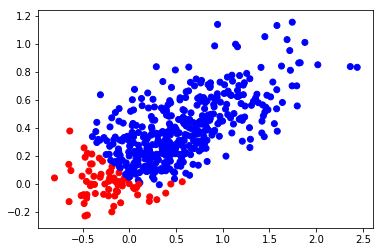

In [16]:
def graph():
    fig, axs = plt.subplots(1,1)
    all = []
    all_out = []
    for k in range(500):
        seed = seed_distribution.sample()
        x_fake = G(seed[0:1])
        out = D(x_fake)        
        all.append(x_fake.data[0].numpy())
        all_out.append(out)
    all = np.array(all)
    out = np.array(all_out)
    axs.scatter(all[:, 0], all[:, 1], color=["blue" if c < 0.5 else "red" for c in out])

graph()

In [30]:
import torchtext.data as data
import torchtext.datasets as datasets
from torchtext.vocab import GloVe

This part is slow to run on CPU. But it shows the setup for a Miao (2016) type VAE over text. Here we use powerful encoder in the form of a LSTM. But use a very simple generative model that predicts a set of works (in binary represenation) as the output. The aim is that the latent variable should learn something akin to a topic about the words themseles. 

In [31]:
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

# make splits for data
train, test = datasets.TREC.splits(TEXT, LABEL, fine_grained=True)
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=100))
LABEL.build_vocab(train)

In [32]:
WORD_DIM = 100
LATENT_DIM = 32
num_embeddings = len(TEXT.vocab)

# LSTM Encoder / Inference Network
class Encoder(nn.Module):
    def __init__(self, num_embeddings):
        super(Encoder, self).__init__()
        self.emb_layer = nn.Embedding(embedding_dim=WORD_DIM, 
                                      num_embeddings=num_embeddings)
        self.emb_layer.weight.data = TEXT.vocab.vectors.clone()
        self.enc_layer = nn.LSTM(input_size=WORD_DIM, hidden_size=WORD_DIM)
        self.mu_layer = nn.Linear(WORD_DIM, LATENT_DIM)
        self.logvar_layer = nn.Linear(WORD_DIM, LATENT_DIM)
        
    def forward(self, src):
        emb = self.emb_layer(src)
        output, _  = self.enc_layer(emb)
        final = output[:, -1]
        mu = self.mu_layer(final)
        logvar = self.logvar_layer(final)
        return mu, logvar

In [33]:
# Bag-of-Word Generative Model
class Decoder(nn.Module):
    def __init__(self, num_embeddings):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(LATENT_DIM, 200)
        self.layer2 = nn.Linear(200, num_embeddings)
    def forward(self, hidden):
        return self.layer2(F.relu(self.layer1(hidden)))


In [53]:
BATCH_SIZE = 32
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=BATCH_SIZE, device=-1)
bce = nn.BCEWithLogitsLoss(size_average=False)
encoder = Encoder(len(TEXT.vocab))
decoder = Decoder(len(TEXT.vocab))
vae = NormalVAE(encoder, decoder)
learning_rate = 0.01
optim = torch.optim.SGD(vae.parameters(), lr = learning_rate)
#optim = torch.optim.Adam(vae.parameters(), lr = learning_rate)
NUM_EPOCHS = 50
p = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), V(torch.ones(BATCH_SIZE, LATENT_DIM)))

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_kl = 0
    total = 0
    alpha = 1
    for i, t in enumerate(train_iter):
        if t.label.size(0) != BATCH_SIZE : continue
        vae.zero_grad()
        x, _ = t.text
        out, q = vae(x)
        kl = kl_divergence(q, p).sum()
        target = torch.zeros(BATCH_SIZE, len(TEXT.vocab)).float()
        for b in range(BATCH_SIZE):
            target[b][t.text[0].data[b]] =  1   
        loss = bce(out.view(-1), V(target.view(-1) ) ) + alpha * kl 
        loss = loss / BATCH_SIZE
        
        total_loss += bce(out.view(-1), V(target.view(-1) ) ).data / BATCH_SIZE
        total_kl += kl.data / BATCH_SIZE
        total += 1
        loss.backward()
        optim.step()
    print(i, total_loss[0] / total , total_kl[0] / total)

KeyboardInterrupt: 